In [4]:
import os
import pandas as pd
from sqlalchemy import create_engine


postgres_host = '40.89.151.14' #os.environ['APP_POSTGRES_HOST']
database = 'postgres'
port = '5433'
user = 'mai'
password = '1930'

engine = create_engine(
    f'postgresql://{user}:{password}@{postgres_host}:{port}/{database}'
)

sql_str = """
SELECT
    date,
    country,
    SUM(content_watch)::float / SUM(content_impression)::float as conversion
FROM (
    SELECT
        user_id_for_mai,
        content_id,
        country,
        to_char(to_timestamp(rocket_datetime), 'YYYY-MM-DD') as date,
        MAX(CASE WHEN name in ('page_impression', 'click') THEN 1 ELSE 0 END) as content_impression,
        MAX(CASE WHEN name='content_watch' THEN 1 ELSE 0 END) as content_watch
    FROM movie.events
    WHERE
        content_id > 0
        AND extract(dow FROM to_timestamp(rocket_datetime)) < 6
    GROUP BY user_id_for_mai, content_id, date, country
) as content_watches
WHERE
    content_impression > 0
GROUP BY date, country
ORDER BY date, country
"""

conversion_df = pd.read_sql(sql_str, engine)

conversion_df.head()

print(conversion_df)

            date     country  conversion
0     2019-06-02    Беларусь    0.333333
1     2019-06-02   Казахстан    0.444444
2     2019-06-02      Латвия    0.000000
3     2019-06-02       Литва    0.000000
4     2019-06-02    Молдавия    0.285714
...          ...         ...         ...
1093  2019-08-30         США    0.000000
1094  2019-08-30   Туркмения    0.705882
1095  2019-08-30  Узбекистан    0.833333
1096  2019-08-30     Украина    0.443850
1097  2019-08-30     Эстония    0.000000

[1098 rows x 3 columns]


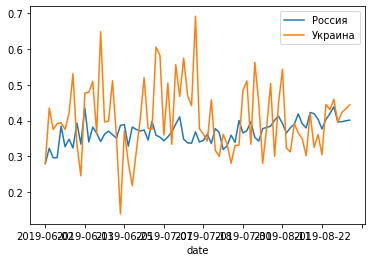

In [37]:
%matplotlib inline

df1 = conversion_df[conversion_df['country']=='Россия']
df2 = conversion_df[conversion_df['country']=='Украина']


ax = df1.plot(x='date', y='conversion', label='Россия')
df2.plot(x='date', y='conversion', ax=ax, label='Украина')

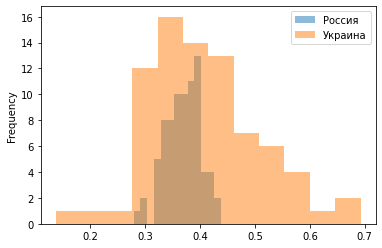

In [39]:
# Windows 10
ax = conversion_df[
    conversion_df['country']=='Россия'
]['conversion'].plot(kind='hist', alpha=0.5, bins=13, label='Россия', legend=True)

# xboxOne
conversion_df[
    conversion_df['country']=='Украина'
]['conversion'].plot(kind='hist', alpha=0.5, bins=12, label='Украина', legend=True)

In [15]:
sql_str2 = """
SELECT user_id_for_mai, to_timestamp(rocket_datetime) FROM movie.events
WHERE extract(dow FROM to_timestamp(rocket_datetime)) = 5 LIMIT 3
"""
conversion_df2 = pd.read_sql(sql_str2, engine)
print(conversion_df2)

   user_id_for_mai              to_timestamp
0       5091747750 2019-08-30 17:48:33+00:00
1       5058555330 2019-08-30 18:31:50+00:00
2       5091747750 2019-08-30 19:02:51+00:00


In [47]:
sql_str3 = """

WITH int AS(
SELECT count(*) as count1 FROM
(SELECT user_id_for_mai, subsite_title FROM movie.events
WHERE to_timestamp(rocket_datetime) < ('2019-08-12'::timestamp - '7 days'::interval)
        AND to_timestamp(rocket_datetime) > ('2019-08-12'::timestamp - '14 days'::interval)
GROUP BY user_id_for_mai, subsite_title
INTERSECT
SELECT user_id_for_mai, subsite_title FROM movie.events
WHERE to_timestamp(rocket_datetime) < ('2019-08-12'::timestamp)
        AND to_timestamp(rocket_datetime) > ('2019-08-12'::timestamp - '6 days'::interval)
GROUP BY user_id_for_mai, subsite_title) AS date1
),
un AS (
SELECT count(*) as count2 FROM
(SELECT user_id_for_mai, subsite_title FROM movie.events
WHERE to_timestamp(rocket_datetime) < ('2019-08-12'::timestamp - '7 days'::interval)
        AND to_timestamp(rocket_datetime) > ('2019-08-12'::timestamp - '14 days'::interval)
GROUP BY user_id_for_mai, subsite_title
UNION
SELECT user_id_for_mai, subsite_title FROM movie.events
WHERE to_timestamp(rocket_datetime) < ('2019-08-12'::timestamp)
        AND to_timestamp(rocket_datetime) > ('2019-08-12'::timestamp - '6 days'::interval)
GROUP BY user_id_for_mai, subsite_title) AS date2
)

SELECT count1::float/count2::float FROM
int CROSS JOIN un
"""
retention = pd.read_sql(sql_str3, engine)
retention.head()
print(retention)

   ?column?
0  0.224091


In [10]:
rus_conversion_sum = 0
ukr_conversion_sum = 0
for i in conversion_df[conversion_df['country'] == 'Россия'].conversion:
    rus_conversion_sum = rus_conversion_sum + i
    
for j in conversion_df[conversion_df['country'] == 'Украина'].conversion:
    ukr_conversion_sum = ukr_conversion_sum + j


rus_conversion = rus_conversion_sum/len(conversion_df[conversion_df['country'] == 'Россия'])
ukr_conversion = ukr_conversion_sum/len(conversion_df[conversion_df['country'] == 'Украина']) 

print(rus_conversion, ukr_conversion)

0.3688687176282983 0.40484941529125634


In [12]:
import math
from scipy.stats import norm

n1_click = len(conversion_df[conversion_df['country'] == 'Россия'])

n2_click = len(conversion_df[conversion_df['country'] == 'Украина']) 

# ctr
p1 = rus_conversion
p2 = ukr_conversion

p = ((p1*n1_click + p2*n2_click)/(n1_click + n2_click))

# значение статистики критерия
T_x = ((p1-p2)/math.sqrt(p*(1-p)*((1/n1_click) + (1/n2_click))))

# квантиль уровня 0.95 нормального распределения
z_095 = norm.ppf(0.95)

print("Верная ли нулевая гипотеза о неравенстве долей: {}".format(T_x != z_095))



Верная ли нулевая гипотеза о неравенстве долей: True
